## Imports

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, OrderedDict
from xgboost import XGBRanker, plot_importance
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle


## Reading and splitting the data

In [2]:
%%time
df_train = pd.read_csv('~/Desktop/DMT/train_reduced.csv', index_col=0)
# df_valid = pd.read_csv('~/Desktop/DMT/valid_pc.csv', index_col=0)
# df_train = pd.read_csv('~/Desktop/DMT/train_set_VU_DM.csv')
df_test = pd.read_csv('~/Desktop/DMT/test_set_VU_DM.csv')

CPU times: user 28.1 s, sys: 8.01 s, total: 36.1 s
Wall time: 35.1 s


In [3]:
df_train = shuffle(df_train)

In [4]:
X_train, X_valid, y_train, y_valid = train_test_split(
    df_train, df_train.click_bool, test_size=1/3)

In [5]:
groups_size_train = OrderedDict(
    sorted(dict(X_train.srch_id.value_counts()).items()))

groups_size_valid = OrderedDict(
    sorted(dict(X_valid.srch_id.value_counts()).items()))


## Normalization

The main idea is to normalize/standardize (mean = 0 and standard deviation = 1) all features before applying classification. Standard Scaler from scikit-learn will normalize the features individually so that each feature column have mean = 0 and standard deviation = 1.

[Importance of Feature Scaling](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html#sphx-glr-auto-examples-preprocessing-plot-scaling-importance-py)

In [6]:
# Normalizing training set

model = StandardScaler()
y_train = X_train.click_bool.values

X_train = X_train.drop([
    'click_bool', 'gross_bookings_usd', 'booking_bool', 'date_time', 'position',
    'srch_id', 'prop_id'
],
                       axis=1).values

model.fit(X_train)
X_train = model.transform(X_train)


In [7]:
# Normalizing validation set

y_valid = X_valid.click_bool.values

X_valid = X_valid.drop([
    'click_bool', 'gross_bookings_usd', 'booking_bool', 'date_time', 'position',
    'srch_id', 'prop_id'
],
                       axis=1).values

X_valid = model.transform(X_valid)


In [8]:
# Test set for predictions

X_test = df_test.drop(['date_time', 'srch_id', 'prop_id'], axis=1).values

X_test = model.transform(X_test)

## Training the model

Using LambdaMART to perform list-wise ranking where Normalized Discounted Cumulative Gain (NDCG) is maximized, evaluation with NDCG@5

In [9]:
# Gradient boosting algorithm

model = XGBRanker(
    n_jobs=15,
    objective='rank:ndcg',
    learning_rate=.1,
    max_depth=7,
    n_estimators=1500)

model.fit(
    X_train,
    y_train,
    group=list(groups_size_train.values()),
    eval_metric='ndcg@5',
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_group=[
        list(groups_size_train.values()),
        list(groups_size_valid.values())
    ],
    early_stopping_rounds=100)


XGBRanker(base_score=0.5, booster='gbtree', colsample_bylevel=1,
     colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
     max_depth=7, min_child_weight=1, missing=None, n_estimators=1500,
     n_jobs=15, nthread=None, objective='rank:ndcg', random_state=0,
     reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
     subsample=1)

In [10]:
model.best_score

0.981753

## Predicting on the test set

In [11]:
y_pred = model.predict(X_test)

In [12]:
df_pred = pd.DataFrame(y_pred, columns=['score'], index=df_test.index)

In [13]:
df_pred['srch_id'] = df_test.srch_id
df_pred['prop_id'] = df_test.prop_id

In [14]:
df_pred.sort_values(['srch_id', 'score'], ascending=[True, False], inplace=True)

In [15]:
df_pred.drop(['score'], axis=1, inplace=True)
df_pred.reset_index(drop=True, inplace=True)

In [16]:
df_pred.to_csv('~/Desktop/DMT/submission04.csv', index=False)

## Feature importance plotting

In [17]:
sns.set(
    style='whitegrid',
    palette='Set2',
    font_scale=1.4,
    rc={"figure.figsize": [10, 14]})


In [22]:
# set feature names for the predictor
model.get_booster().feature_names = list(
    df_train.drop([
        'click_bool', 'gross_bookings_usd', 'booking_bool', 'date_time',
        'position', 'srch_id', 'prop_id'
    ],
                  axis=1).columns)


Feature importance scores:

* "weight" is the number of times a feature appears in a tree
* "gain" is the average gain of splits which use the feature
* "cover" is the average coverage of splits which use the feature where coverage is defined as the number of samples affected by the split

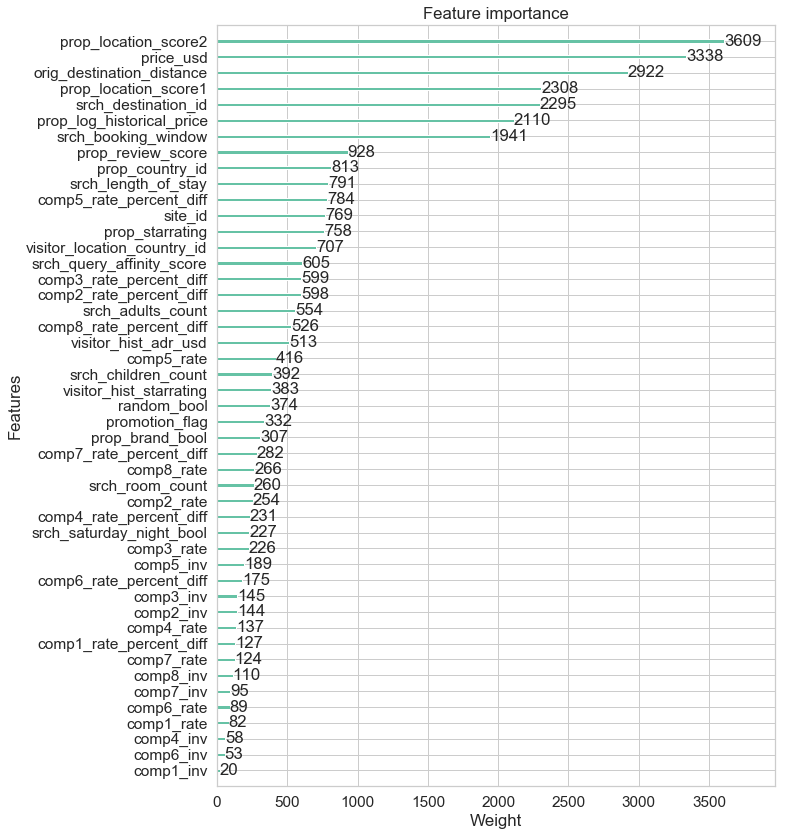

In [23]:
plot_importance(model)
plt.xlabel('Weight')
plt.show()

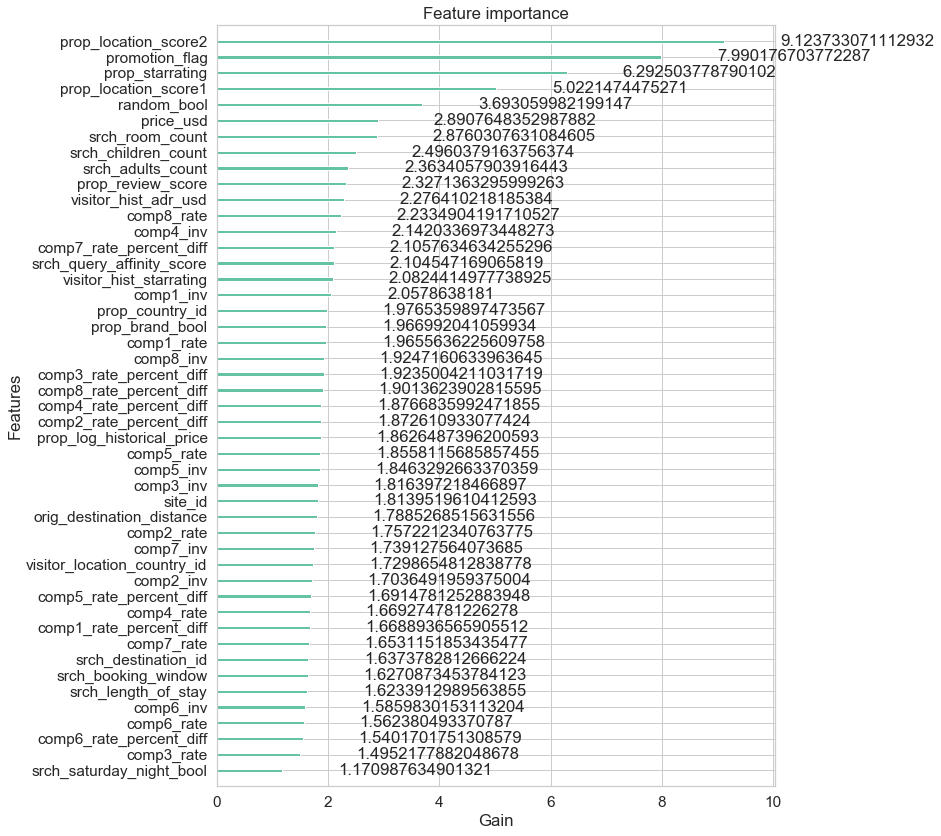

In [24]:
plot_importance(model, importance_type='gain')
plt.xlabel('Gain')
plt.show()

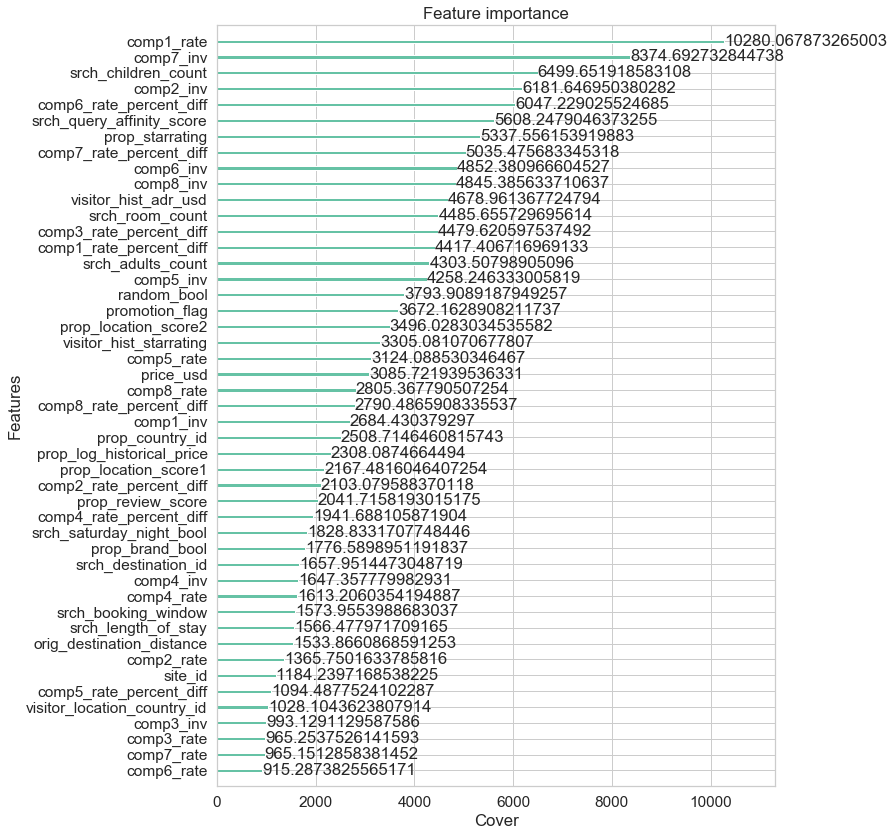

In [25]:
plot_importance(model, importance_type='cover')
plt.xlabel('Cover')
plt.show()

## Grid search and parameters tuning

In [ ]:
GridSearchCV()